In [ ]:
# default_exp uniform

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# stellt sicher, dass beim verändern der core library diese wieder neu geladen wird
%load_ext autoreload
%autoreload 2

# uniform and complete

...

## Basic Settings

In [ ]:
# imports
from bfh_mt_hs2020_sec_data.core import get_spark_session # initialze spark
from pathlib import Path
from typing import List, Tuple, Union, Set
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.functions import col

import pandas as pd

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

In [ ]:
all_pivot_selected_folder  = "D:/data/parq_pivot_select"
all_pivoted_folder = "D:/data/parq_pivot_split"
all_processed_folder = "D:/data/parq_processed/"

col_list =    ["stmt","cik","ticker", "adsh","period","form","tag","value","report", "line", "fp", "uom"]
pivot_attrs = ['value', 'report', 'line']
statements =  ['IS','CF','CP','BS','CI','EQ','UN']

In [ ]:
# init Spark
spark = get_spark_session() # Session anlegen
spark # display the moste important information of the session

## 00_Tools

In [ ]:
def load_data(stmt:str, attr:str):
    return spark.read.parquet(all_pivoted_folder + "/" + stmt + "/" + attr).cache()

In [ ]:
def spark_shape(self):
    return (self.count(), len(self.columns))

In [ ]:
### Get count of both null and missing values in pyspark
from pyspark.sql.functions import isnan, when, count, col
def get_empty_count(df):
    return df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

In [ ]:
def complete_addition(df, sumcol, addcol1, addcol2):
    missingtwo = (df[sumcol].notnull()) & (df[addcol1].notnull()) & (df[addcol2].isnull())
    df.loc[missingtwo, addcol2] = df.loc[missingtwo, sumcol] - df.loc[missingtwo, addcol1]

    missingone = (df[sumcol].notnull()) & (df[addcol2].notnull()) & (df[addcol1].isnull())
    df.loc[missingone, addcol1] = df.loc[missingone, sumcol] - df.loc[missingone, addcol2]  
    
    missingsum = (df[sumcol].isnull()) & (df[addcol2].notnull()) & (df[addcol1].notnull())
    df.loc[missingsum, sumcol] = df.loc[missingsum, addcol1] + df.loc[missingsum, addcol2]  

In [ ]:
def copy_if_not_empty(df, sourcecol, targetcol, to_zero_col = None):
    do_copy = (df[sourcecol].notnull()) & (df[targetcol].isnull())
    df.loc[do_copy, targetcol] = df.loc[do_copy, sourcecol]
    if to_zero_col != None:
        df.loc[do_copy, to_zero_col] = 0.0

In [ ]:
def df_copy_if_not_empty(src_df, sourcecol, tgt_df, targetcol, joincol):
    
    
    
    do_copy = (df[sourcecol].notnull()) & (df[targetcol].isnull())
    df.loc[do_copy, targetcol] = df.loc[do_copy, sourcecol]

In [ ]:
def copy_if_not_empty_for_ticker(df, ticker, sourcecol, targetcol, to_zero_col = None):
    do_copy = (df['ticker'] == ticker) & (sel_df[sourcecol].notnull()) & (sel_df[targetcol].isnull())

    df.loc[do_copy, targetcol] = df.loc[do_copy, sourcecol]
    if to_zero_col != None:
        df.loc[do_copy, to_zero_col] = 0.0

In [ ]:
def set_to_zero_if_null(df, col):
    do_set = (df[col].isnull())
    df.loc[do_set, col] = 0.0

In [ ]:
def print_null_count(df, cols):
    for col in cols:
        print(col, ' ', df[col].isnull().sum())

## 00_Raw_data

In [ ]:
df_all_selected = spark.read.parquet(all_pivot_selected_folder).cache()

In [ ]:
# it happens sometimes, that the data can not be associated with a right sheet (bs, is, cf, ..). in this cases, the data can appea under "UN"
# so if expected information cannot be found in the appropriate statement, we have to look in the un statement
un_pivot_value = load_data("UN", "value")
un_pivot_pd = un_pivot_value.toPandas()

In [ ]:
un_pivot_pd.shape

(4074, 1958)

## 01_Balance_Sheet

In [ ]:
bs_pivot_value = load_data("BS", "value")
spark_shape(bs_pivot_value)

(133872, 2342)

In [ ]:
bs_pivot_pd = bs_pivot_value.toPandas()

In [ ]:
bs_pivot_pd_copy = bs_pivot_pd.copy()

### Assets

In [ ]:
print_null_count(bs_pivot_pd_copy, ['Assets','AssetsNoncurrent','AssetsCurrent'])

Assets   579
AssetsNoncurrent   127026
AssetsCurrent   30421


In [ ]:
copy_if_not_empty(bs_pivot_pd_copy, 'AssetsNet', 'Assets')
complete_addition(bs_pivot_pd_copy, 'Assets', 'AssetsCurrent', 'AssetsNoncurrent')
# if Assets contains data and current not, copy from Assets to current and set noncurrent to 0.0
copy_if_not_empty(bs_pivot_pd_copy, 'Assets', 'AssetsCurrent', 'AssetsNoncurrent')
# if AssetsCurrent contains data and Assets does not, copy to Assets ans set noncurrent t 0.0
copy_if_not_empty(bs_pivot_pd_copy, 'AssetsCurrent', 'Assets', 'AssetsNoncurrent')

In [ ]:
print_null_count(bs_pivot_pd_copy, ['Assets','AssetsNoncurrent','AssetsCurrent'])

Assets   419
AssetsNoncurrent   419
AssetsCurrent   419


In [ ]:
bs_pivot_pd_copy.shape

(133872, 2342)

### Liabilities

In [ ]:
print_null_count(bs_pivot_pd_copy, ['Liabilities','LiabilitiesNoncurrent','LiabilitiesCurrent'])

Liabilities   34118
LiabilitiesNoncurrent   117766
LiabilitiesCurrent   30837


In [ ]:
complete_addition(bs_pivot_pd_copy, 'Liabilities', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent')
# if Liabilities contains data and current is empty, copy to current and set NonCurrent to 0.0
copy_if_not_empty(bs_pivot_pd_copy, 'Liabilities', 'LiabilitiesCurrent', 'LiabilitiesNoncurrent')
# if only current Liabilities, copy to Liabilities and set Noncurrent to 0.0
copy_if_not_empty(bs_pivot_pd_copy, 'LiabilitiesCurrent', 'Liabilities', 'LiabilitiesNoncurrent')

In [ ]:
print_null_count(bs_pivot_pd_copy, ['Liabilities','LiabilitiesNoncurrent','LiabilitiesCurrent'])

Liabilities   783
LiabilitiesNoncurrent   781
LiabilitiesCurrent   783


In [ ]:
bs_pivot_pd_copy.shape

(133872, 2342)

### Equity

In [ ]:
print_null_count(bs_pivot_pd_copy, ['StockholdersEquity','RetainedEarningsAccumulatedDeficit','LiabilitiesAndStockholdersEquity'])

StockholdersEquity   12883
RetainedEarningsAccumulatedDeficit   10583
LiabilitiesAndStockholdersEquity   710


In [ ]:
copy_if_not_empty(bs_pivot_pd_copy, 'Assets', 'LiabilitiesAndStockholdersEquity') # has to be the same
copy_if_not_empty(bs_pivot_pd_copy, 'PartnersCapital', 'StockholdersEquity') # if there is partner capital, we consider it the same as stockholder equity
copy_if_not_empty(bs_pivot_pd_copy, 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest', 'StockholdersEquity') #dito
set_to_zero_if_null(bs_pivot_pd_copy, 'RetainedEarningsAccumulatedDeficit')

In [ ]:
print_null_count(bs_pivot_pd_copy, ['StockholdersEquity','RetainedEarningsAccumulatedDeficit','LiabilitiesAndStockholdersEquity'])

StockholdersEquity   1277
RetainedEarningsAccumulatedDeficit   0
LiabilitiesAndStockholdersEquity   409


In [ ]:
bs_pivot_pd_copy.shape

(133872, 2342)

### Clean empty companies

In [ ]:
bs_cols_selected = bs_pivot_pd_copy[["cik","ticker", "adsh","period","form", 
                                     'Assets','AssetsNoncurrent', 'AssetsCurrent', 
                                     'Liabilities','LiabilitiesNoncurrent','LiabilitiesCurrent', 
                                     'StockholdersEquity','RetainedEarningsAccumulatedDeficit']]

In [ ]:
incomplete_ciks = bs_cols_selected[bs_cols_selected.isnull().sum(axis=1) > 0].cik.unique()

In [ ]:
bs_cols_cleaned = bs_cols_selected[~bs_pivot_pd_copy.cik.isin(incomplete_ciks)]

In [ ]:
bs_cols_cleaned.shape

(124520, 13)

In [ ]:
bs_cols_cleaned.isnull().sum(axis=1).sum()

0

### Save

In [ ]:
bs_cols_cleaned.to_csv(all_processed_folder + "bs.csv", index=False)

## CashFlow

Operation
- NetIncomeLoss
- NetCashProvidedByUsedInOperatingActivities: NetIncome + other positions ergibt diese Position

Investing
- NetCashProvidedByUsedInInvestingActivities

Financing activities
- PaymentsForRepurchaseOfCommonStock: Aktienrückkäufe
- PaymentsOfDividends
- NetCashProvidedByUsedInFinancingActivities

Cash Bestand unterschied
- CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect: increase/decrease in cash

In [ ]:
cf_pivot_value = load_data("CF", "value")
spark_shape(cf_pivot_value)

(133811, 3052)

In [ ]:
cf_empty_count = get_empty_count(cf_pivot_value)

In [ ]:
cf_pivot_pd = cf_pivot_value.toPandas()

In [ ]:
cf_pivot_pd_copy = cf_pivot_pd.copy()

In [ ]:
cf_pivot_pd.shape

(133811, 3052)

### Cash Increase/Decrease
- 'CashAndCashEquivalentsPeriodIncreaseDecrease',
- 'CashAndCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
- 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
- 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect',
- 'CashPeriodIncreaseDecrease',
- 'CashPeriodIncreaseDecreaseExcludingExchangeRateEffect',

In [ ]:
print_null_count(cf_pivot_pd_copy, ['CashAndCashEquivalentsPeriodIncreaseDecrease'])

CashAndCashEquivalentsPeriodIncreaseDecrease   30244


In [ ]:
# add possible columns from un set to  cf data with prefix cpy_
un_cash_incdec = un_pivot_pd[["adsh",
    'CashAndCashEquivalentsPeriodIncreaseDecrease',
    'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect',
    'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
#    'CashPeriodIncreaseDecrease',
#    'CashAndCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
#    'CashPeriodIncreaseDecreaseExcludingExchangeRateEffect' 
]].copy()
un_cash_incdec.rename(columns=lambda x: "cpy_" + x, inplace=True)
un_cash_incdec.rename(columns={'cpy_adsh':'adsh'}, inplace=True)

In [ ]:
cf_pivot_pd_copy = pd.merge(cf_pivot_pd_copy, un_cash_incdec, how='left', on=['adsh'])
cf_pivot_pd_copy.shape

(133811, 3055)

In [ ]:
# if CashAndCashEquivalentsPeriodIncreaseDecrease is not present and CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect
# is present, we can replace CashAndCashEquivalentsPeriodIncreaseDecrease.
# there are only about 12 entries where both are present
copy_if_not_empty(cf_pivot_pd_copy, 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'CashPeriodIncreaseDecrease', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'CashAndCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'CashPeriodIncreaseDecreaseExcludingExchangeRateEffect', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'NetCashProvidedByUsedInContinuingOperations', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or


# try to find data in joined un data
copy_if_not_empty(cf_pivot_pd_copy, 'cpy_CashAndCashEquivalentsPeriodIncreaseDecrease', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'cpy_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or
copy_if_not_empty(cf_pivot_pd_copy, 'cpy_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect', 
                                    'CashAndCashEquivalentsPeriodIncreaseDecrease') # either or

In [ ]:
print_null_count(cf_pivot_pd_copy, ['CashAndCashEquivalentsPeriodIncreaseDecrease'])

CashAndCashEquivalentsPeriodIncreaseDecrease   1563


# xx_trials

In [ ]:
cf_pivot_pd_copy[(cf_pivot_pd_copy.StockholdersEquity.isnull())  ][["cik","ticker", "adsh","period", "StockholdersEquityBeforeTreasuryStock", "LiabilitiesAndStockholdersEquity", "RetainedEarningsAccumulatedDeficit"]].sort_values(by=['period'])

In [ ]:
selected = bs_piivot_pd_copy['ticker'] == 'FXE'
sel_df = bs_piivot_pd_copy.loc[selected]
do_copy = (sel_df['AssetsCurrent'].notnull()) & (sel_df['Assets'].isnull())
do_copy.sum()

34

In [ ]:
cf_pivot_pd_copy[(cf_pivot_pd_copy.CashAndCashEquivalentsPeriodIncreaseDecrease.isnull())  \
 #                 &(cf_pivot_pd_copy.NetCashProvidedByUsedInContinuingOperations.notnull())
                ] \
  [["cik","ticker", "adsh","period", 
    'CashAndCashEquivalentsPeriodIncreaseDecrease',
    'NetCashProvidedByUsedInContinuingOperations',
    'cpy_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect',
    #    'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
#    'CashPeriodIncreaseDecrease',
#    'CashAndCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
#    'CashPeriodIncreaseDecreaseExcludingExchangeRateEffect',   

    ]] \
    .sort_values(by=['period'])

,cik,ticker,adsh,period,CashAndCashEquivalentsPeriodIncreaseDecrease,NetCashProvidedByUsedInContinuingOperations,cpy_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect
131510,20171,CB,0000950123-09-032665,2009-06-30,NaN,NaN,NaN
69851,831001,C,0001047469-09-009754,2009-09-30,NaN,NaN,NaN
45994,20171,CB,0000950123-09-059260,2009-09-30,NaN,NaN,NaN
7912,874766,HIG,0000950123-09-056913,2009-09-30,NaN,NaN,NaN
72466,899051,ALL,0001104659-09-062522,2009-09-30,NaN,NaN,NaN
...,...,...,...,...,...,...,...
16678,704051,LM,0000704051-20-000060,2020-03-31,NaN,NaN,NaN
17724,867665,AXAS,0001437749-20-014626,2020-03-31,NaN,NaN,NaN
133324,1474439,TNAV,0001474439-20-000023,2020-03-31,NaN,NaN,NaN
103312,704051,LM,0000704051-20-000085,2020-06-30,NaN,NaN,NaN


In [ ]:
bs_pivot_liabilities_copy[(bs_pivot_liabilities_copy.StockholdersEquity.isnull())][["cik","ticker", "adsh","period", "Assets", "StockholdersEquity", "LiabilitiesAndStockholdersEquity", "RetainedEarningsAccumulatedDeficit"]].sort_values(by=['period'])

In [ ]:
bs_pivot_liabilities_copy[(bs_pivot_liabilities_copy.adsh == '0001104659-09-029605')][["cik","ticker", "adsh","period","report", "line"]].sort_values(by=['period'])

['cik',
 'ticker',
 'adsh',
 'form',
 'period',
 'fp',
 'AcceleratedShareRepurchaseProgramAdjustment',
 'AcceleratedShareRepurchasesSettlementPaymentOrReceipt',
 'AccountsAndNotesReceivableNet',
 'AccountsAndOtherReceivablesNetCurrent',
 'AccountsPayableAndAccruedLiabilities',
 'AccountsPayableAndAccruedLiabilitiesCurrentAndNoncurrent',
 'AccountsPayableAndOtherAccruedLiabilities',
 'AccountsPayableCurrent',
 'AccountsPayableCurrentAndNoncurrent',
 'AccountsPayableRelatedPartiesCurrentAndNoncurrent',
 'AccountsPayableRelatedPartiesNoncurrent',
 'AccountsReceivableNet',
 'AccountsReceivableNetCurrent',
 'AccretionAmortizationOfDiscountsAndPremiumsInvestments',
 'AccretionExpense',
 'AccretionExpenseIncludingAssetRetirementObligations',
 'AccretionOfDiscount',
 'AccrualForEnvironmentalLossContingenciesPayments',
 'AccrualForEnvironmentalLossContingenciesPeriodIncreaseDecrease',
 'AccruedInvestmentIncomeReceivable',
 'AccruedLiabilitiesAndOtherLiabilities',
 'AccruedProfessionalFeesCurren

In [ ]:
cf_empty_pd = cf_empty_count.toPandas()

In [ ]:
cf_empty_pd.shape

(1, 3052)

In [ ]:
cf_melt_pd = cf_empty_pd.melt(var_name = 'Tag', value_name = "Count")
cf_melt_pd['diff'] = 133811 -cf_melt_pd['Count']

In [ ]:
canditates =  ['CashAndCashEquivalentsPeriodIncreaseDecrease','cp_CashAndCashEquivalentsPeriodIncreaseDecrease',
 'CashAndCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect',
 'CashPeriodIncreaseDecrease',
 'CashPeriodIncreaseDecreaseExcludingExchangeRateEffect']

cf_melt_pd[cf_melt_pd['Tag'].isin(canditates)]

,Tag,Count,diff
350,CashAndCashEquivalentsPeriodIncreaseDecrease,30244,103567
351,CashAndCashEquivalentsPeriodIncreaseDecreaseEx...,132424,1387
360,CashCashEquivalentsRestrictedCashAndRestricted...,130603,3208
361,CashCashEquivalentsRestrictedCashAndRestricted...,119033,14778
382,CashPeriodIncreaseDecrease,132236,1575
383,CashPeriodIncreaseDecreaseExcludingExchangeRat...,133766,45


<AxesSubplot:xlabel='Tag'>

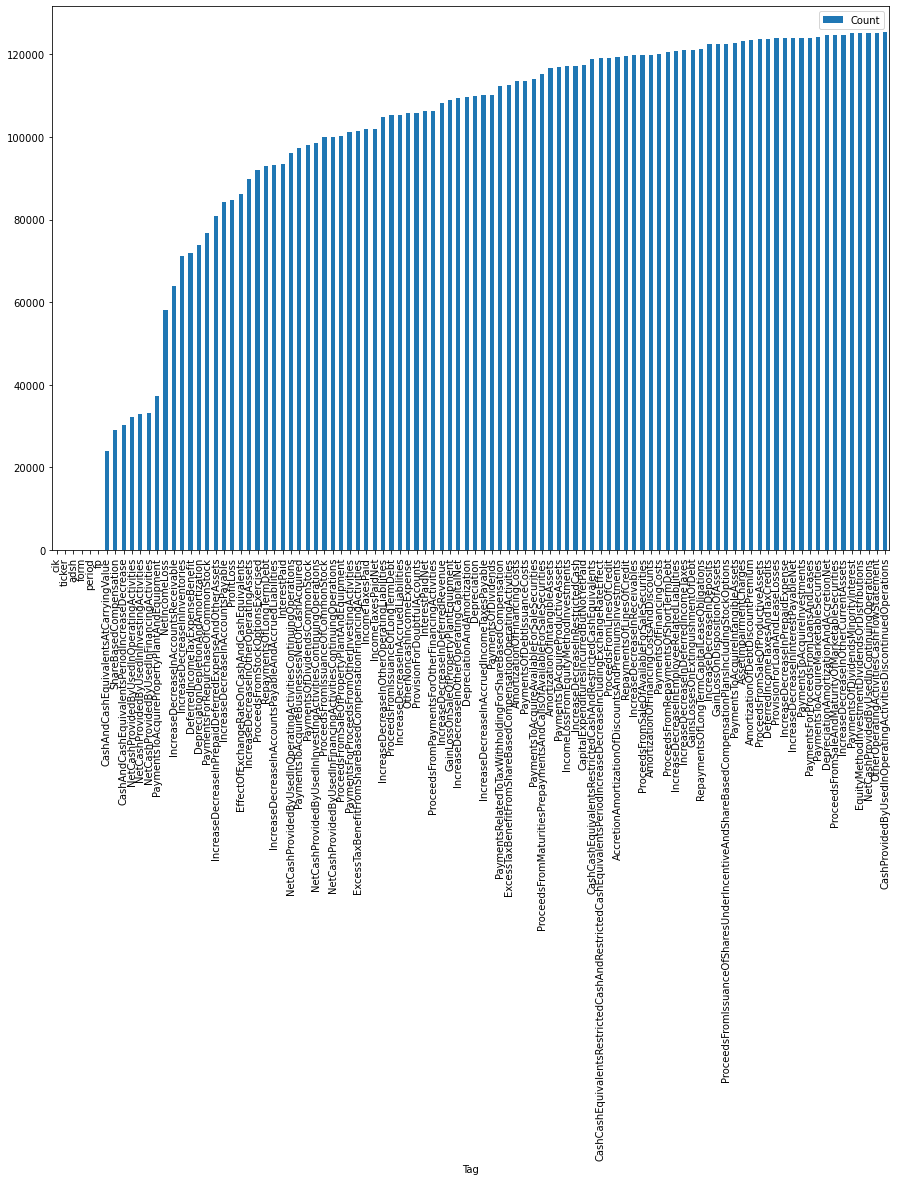

In [ ]:
sorted = cf_melt_pd.sort_values('Count', ascending=True)[:100]
sorted.reset_index(drop = True, inplace = True)
sorted.plot.bar(x = 'Tag', y='Count', figsize = (15,10))

In [ ]:
empty_count = get_empty_count(bs_pivot_value)

In [ ]:
empty_pd = empty_count.toPandas()

In [ ]:
melt_pd = empty_pd.melt(var_name = 'Tag', value_name = "Count")
# df2 = pd.melt(df, id_vars=["location", "name"], var_name="Date", value_name="Value")

In [ ]:
melt_pd.columns

Index(['Tag', 'Count'], dtype='object')

In [ ]:
pd_frame = df_all_selected.where("adsh == '0000704051-20-000085'").toPandas()
#print(pd_frame.sort_values(['report', 'line']))

In [ ]:
pd.set_option('display.max_rows', pd_frame.shape[0]+1)
pd_frame[['tag', 'value', 'stmt', 'report', 'line']].sort_values(['report', 'line'])

,tag,value,stmt,report,line
7,PropertyPlantAndEquipmentNet,1.261130e+08,BS,2,55
4,ShortTermBorrowings,2.500000e+08,BS,2,67
9,LongTermDebtNoncurrent,1.973054e+09,BS,2,75
5,RedeemableNoncontrollingInterestEquityCarrying...,6.133360e+08,BS,2,77
3,CommonStockParOrStatedValuePerShare,1.000000e-01,BS,2,89
8,CommonStockSharesAuthorized,5.000000e+08,BS,2,90
6,CommonStockSharesIssued,9.053494e+07,BS,2,91
16,Revenues,6.661860e+08,IS,3,24
15,IncomeLossFromContinuingOperationsBeforeIncome...,NaN,IS,3,40
14,ProfitLoss,NaN,IS,3,42


In [ ]:
gaap_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect

gaap_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsIncludingDisposalGroupAndDiscontinuedOperations
gaap_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsIncludingDisposalGroupAndDiscontinuedOperations

gaap_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect

gaap_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents
gaap_CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents

In [ ]:
bs_pivot_report.where("adsh == '0001492298-20-000025'").show()

In [ ]:
df_all_selected.select('adsh','stmt').distinct().count()

585411

In [ ]:
df_all_selected.select('adsh','stmt').distinct().where('stmt = "BS"').count()

133872

In [ ]:
df_all_selected.select('adsh','stmt').distinct().where('stmt = "EQ"').count()

86120

In [ ]:
cf_pivot_pd_copy.columns.tolist()

In [ ]:
[x for x in cf_pivot_pd_copy.columns.values if ('IncreaseDecrease' in x) and ('Cash' in x)]

['CashAndCashEquivalentsPeriodIncreaseDecrease',
 'CashAndCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseExcludingExchangeRateEffect',
 'CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalentsPeriodIncreaseDecreaseIncludingExchangeRateEffect',
 'CashPeriodIncreaseDecrease',
 'CashPeriodIncreaseDecreaseExcludingExchangeRateEffect',
 'IncreaseDecreaseCashCollateralFromCounterparties',
 'IncreaseDecreaseInCashCollateralForBorrowedSecurities',
 'IncreaseDecreaseInCashCollateralForLoanedSecurities',
 'IncreaseDecreaseInRestrictedCash',
 'IncreaseDecreaseInRestrictedCashAndInvestments',
 'IncreaseDecreaseInRestrictedCashAndInvestmentsForOperatingActivities',
 'IncreaseDecreaseInRestrictedCashForOperatingActivities',
 'LiabilitiesSubjectToCompromiseCashDisbursementsAndReclassificationIncreaseDecreaseUnderBankruptcyCourtOrderResolutionsOfContingenciesSubjectToChapter11',
 'LoansReceiv

In [ ]:
[x for x in bs_pivot_liabilities_copy.columns.values if x.startswith('StockholdersEquity')]

['StockholdersEquity',
 'StockholdersEquityAttributableToParentNotAllowableForNetCapital',
 'StockholdersEquityBeforeTreasuryStock',
 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest',
 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterestAdjustedBalance1',
 'StockholdersEquityNoteStockSplitConversionRatio',
 'StockholdersEquityNoteStockSplitConversionRatio1',
 'StockholdersEquityNoteSubscriptionsReceivable']